In [1]:
%matplotlib inline

In [2]:
import os

os.chdir("..")

In [3]:
from neuralforecast.models import NBEATS
from neuralforecast import NeuralForecast
from utils import load_dataset, train_test_split
from models.NBeatsMoe import NBeatsMoe, NBEATSMoEBlock
import torch.nn as nn
import pandas as pd

# datasets list
datasets = [
    {
        "name": "m3",
        "directory": "C:\\Users\\ricar\\mixture_of_experts_time_series\\data\\m3\\",
        "group": "Monthly",
        "freq": "M",
    },
    # {
    #     "name": "m4",
    #     "directory": "C:\\Users\\ricar\\mixture_of_experts_time_series\\data\\m4\\",
    #     "group": "Monthly",
    #     "freq": "M",
    # } 
]

/home/ricardo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-20 01:02:36,161	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-04-20 01:02:36,294	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [4]:
# Y_ALL_m4 = load_dataset("m4", datasets[1])
# Y_ALL_m3 = load_dataset("m3", datasets[0])
n_lags = 36
horizon = 18

Let's define the models and the gates to evaluate ...

In [5]:
from neuralforecast.losses.numpy import smape

def calculate_smape(Y_test, predictions, model_name):
    y_true = Y_test['y'].values
    y_hat = predictions[model_name].values

    n_series = Y_test['unique_id'].nunique()
    y_true = y_true.reshape(n_series, -1)
    y_hat = y_hat.reshape(n_series, -1)

    smape_value = smape(y_true, y_hat)
    return smape_value

In [ ]:
results = []
gate_type_list = ["no_gate", "linear", "mlp", "conv1d-flatten", "conv1d-gap"]

for gate_type in gate_type_list:
    for dataset in datasets:
        
        # Load dataset
        Y_ALL = load_dataset(dataset["name"], dataset)
        # Train test split
        Y_train, Y_test = train_test_split(Y_ALL, horizon)
        
        for i in range(10):
            # Define model
            if gate_type == "no_gate":
                model = NBEATS(
                    h=horizon,
                    input_size=n_lags,
                    mlp_units=3*[[256,256]],
                    max_steps=5000,
                    early_stop_patience_steps=10,
                    random_seed=i
                )
            else:
                model = NBeatsMoe(
                    h=horizon,
                    input_size=n_lags,
                    nr_experts=4,
                    top_k=2,
                    mlp_units=3*[[128,128]],
                    gate_type=gate_type,
                    max_steps=5000,
                    early_stop_patience_steps=10,
                    random_seed=i,
                )
            
            # Define NeuralForecast, fit and predict
            nf = NeuralForecast(models=[model], freq=dataset["freq"])
            nf.fit(df=Y_train, static_df=None, val_size=horizon)
            predictions = nf.predict(futr_df=Y_test)
            
            # Calculate SMAPE
            smape_value = calculate_smape(Y_test, predictions, model_name=model.__class__.__name__)
            
            # Save result
            results.append({
                "dataset": dataset["name"],
                "gate_type": gate_type,
                "smape": smape_value,
                "random_seed": i,
            })

# Create and display the results DataFrame
results_df = pd.DataFrame(results)
results_df

Loading m3_monthly dataset...


In [7]:
results_df

,dataset,gate_type,smape,random_seed
0,m3,no_gate,0.163146,0
1,m3,no_gate,0.170551,1
2,m3,linear,0.169973,0
3,m3,linear,0.167532,1
4,m3,mlp,0.168169,0
5,m3,mlp,0.169032,1
6,m3,conv1d-flatten,0.169982,0
7,m3,conv1d-flatten,0.167517,1
8,m3,conv1d-gap,0.167705,0
9,m3,conv1d-gap,0.165932,1


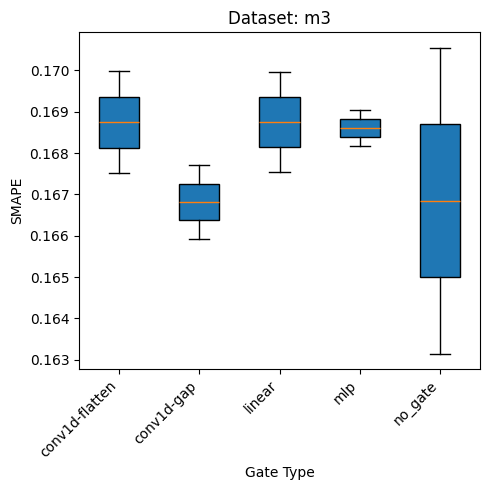

In [8]:
import matplotlib.pyplot as plt

datasets_unique = results_df['dataset'].unique()
n = len(datasets_unique)

fig, axes = plt.subplots(1, n, figsize=(5 * n, 5), sharey=True)
if n == 1:
    axes = [axes]

for ax, ds in zip(axes, datasets_unique):
    subset = results_df[results_df['dataset'] == ds]
    pivot = subset.pivot(index='random_seed', columns='gate_type', values='smape')
    
    # Build a list of arrays (one per gate_type) to avoid label mismatch
    data_to_plot = [pivot[col].values for col in pivot.columns]
    ax.boxplot(data_to_plot, labels=pivot.columns, patch_artist=True)
    
    ax.set_title(f'Dataset: {ds}')
    ax.set_xlabel('Gate Type')
    ax.set_xticklabels(pivot.columns, rotation=45, ha='right')

axes[0].set_ylabel('SMAPE')
plt.tight_layout()
plt.show()
